# Analyzing the radial distribution of Galactic disc Cepheids
## using the sample of Pietrukowicz+2021

In [1]:
# MIT License
# 2022-25 F. Anders, C. Padois (ICCUB)

In [2]:
import os.path
import numpy as np
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
import matplotlib
import matplotlib.ticker as ticker
%matplotlib notebook

import seaborn as sns
import astropy.table
from astropy.table import Table
import astropy.units as u
import pandas as pd
from scipy.stats import gaussian_kde

import cepheid_utils
import importlib

In [3]:
import scipy as sc
import matplotlib.cm as cm
from matplotlib import rc
rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('font',**{'size':20})

## Read Cepheid data
We start with the latest [list of Galactic Cepheids](https://www.astrouw.edu.pl/ogle/ogle4/OCVS/allGalCep.listID) compiled by [Pietrukowicz+2021](https://ui.adsabs.harvard.edu/abs/2021AcA....71..205P/abstract). 

In [4]:
pietru = Table.read("./data/allGalCep_listID_pietrukowicz2021_april2024.dat", 
                    format="ascii", header_start=8)
pietru

Source,Name,RA(2000.0),Dec(2000.0),RA[deg],Dec[deg],l[deg],b[deg],Mode(s),P_F[day],P_1O[day],P_2O[day],P_3O[day],Bands,OGLE,OGLE-II,OGLE-III,OGLE-IV,ASAS,ASASSN-V,Gaia-DR3,G[mag]
str11,str19,str11,str11,float64,float64,float64,float64,str6,float64,float64,float64,float64,str4,str16,str15,str15,str16,str13,str19,str19,str6
GCVS,CG____Cas,00:00:59.23,+60:57:32.4,0.246798,60.959002,116.845566,-1.315165,F,4.3654004,0.0,0.0,0.0,GV,-,-,-,-,-,202111,429385923752386944,10.969
GCVS,V879__Cas,00:01:45.95,+62:25:27.3,0.441455,62.424256,117.218785,0.10477,F,3.8785736,0.0,0.0,0.0,GV,-,-,-,-,-,202734,429945884408637696,13.077
ZTF-DR2,J000158.43+651445.3,00:01:58.43,+65:14:45.2,0.493453,65.24589,117.780672,2.870037,F,2.6488821,0.0,0.0,0.0,Gr,-,-,-,-,-,-,432188922485600384,15.701
ZTF-DR2,J000225.42+625049.8,00:02:25.41,+62:50:49.8,0.605885,62.847165,117.3734,0.505593,F,2.8136856,0.0,0.0,0.0,Gr,-,-,-,-,-,-,430052537038350976,14.411
ZTF-DR2,J000234.99+650517.9,00:02:34.98,+65:05:17.8,0.645766,65.088288,117.813627,2.703163,F,10.9315041,0.0,0.0,0.0,Gr,-,-,-,-,-,J000234.99+650517.8,432163221401882240,10.604
GCVS,EX____Cas,00:02:41.77,+61:51:39.8,0.674044,61.861069,117.218702,-0.468807,F,4.3054033,0.0,0.0,0.0,GV,-,-,-,-,-,202447,429890595286480384,12.162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASASSN-V,J235519.34+675708.6,23:55:19.33,+67:57:08.9,358.830541,67.952466,117.685438,5.654155,1O,0.0,1.8881727,0.0,0.0,GVr,-,-,-,-,-,AP15632683,2210903379911655808,13.674
GCVS,V1206_Cas,23:56:26.68,+58:01:36.7,359.111163,58.02686,115.68401,-4.068913,F,4.7352538,0.0,0.0,0.0,GVc,-,-,-,-,-,212568,1998384927774603520,11.723


In [5]:
# Print some numbers
print(len(pietru), "Cepheids in the catalogue")
print(len(pietru[pietru["G[mag]"]=="-"]), "have missing Gaia DR3")
print(len(pietru[(pietru["Mode(s)"]=="F") & (pietru["G[mag]"]!="-")]), "F-mode CCs with Gaia")
print(len(pietru[(pietru["Mode(s)"]=="1O") & (pietru["G[mag]"]!="-")]), "first-overtone CCs with Gaia")
print(len(pietru[((pietru["Mode(s)"]=="F") | (pietru["Mode(s)"]=="1O")) & (pietru["G[mag]"]!="-")]), "CCs selected in total")

3647 Cepheids in the catalogue
5 have missing Gaia DR3
2247 F-mode CCs with Gaia
1079 first-overtone CCs with Gaia
3326 CCs selected in total


In [6]:
# Apply the last cut to clean the data
pietru = pietru[((pietru["Mode(s)"]=="F")) & (pietru["G[mag]"]!="-")]
# Add a column
pietru['source_id'] = pietru['Gaia-DR3'].astype(np.int64)
# Keep only relevant columns
pietru.keep_columns(["Name", "Source", "Mode(s)", "P_F[day]", "source_id"])
pietru

Source,Name,Mode(s),P_F[day],source_id
str11,str19,str6,float64,int64
GCVS,CG____Cas,F,4.3654004,429385923752386944
GCVS,V879__Cas,F,3.8785736,429945884408637696
ZTF-DR2,J000158.43+651445.3,F,2.6488821,432188922485600384
ZTF-DR2,J000225.42+625049.8,F,2.8136856,430052537038350976
ZTF-DR2,J000234.99+650517.9,F,10.9315041,432163221401882240
GCVS,EX____Cas,F,4.3054033,429890595286480384
...,...,...,...,...
GCVS,RY____Cas,F,12.1410189,1999252442448732288
GCVS,V407__Cas,F,4.5661723,2012787293154800896


## Xmatch with Gaia DR3

In [7]:
from astroquery.gaia import Gaia
Gaia.login(user="fanders")

INFO: Login to gaia TAP server [astroquery.gaia.core]
Password: ········
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


In [8]:
# Launch query
query = 'select g.source_id, g.l, g.b, g.parallax, g.parallax_error, g.ruwe, '+\
        'g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag '+\
        'from gaiadr3.gaia_source as g, '+\
        'user_fanders.pietrukowicz2021_april2024 as t '+\
        'where t.source_id=g.source_id'
job = Gaia.launch_job_async(query=query)
# Download results
dr3results = job.get_results()
dr3results["SOURCE_ID"].name = "source_id"
# Join with input
data = astropy.table.join(pietru, dr3results, keys=["source_id"], join_type='inner')

INFO: Query finished. [astroquery.utils.tap.core]


## Xmatch with metallicities from Ripepi+2022

In [9]:
# Read the data (downloaded from VizieR)
ripepi22   = Table.read("./data/ripepi2022.fit")
ripepi22["GaiaEDR3"].name = "source_id"
ripepi22.keep_columns(["source_id", "__Fe_H_", "e__Fe_H_", "r__Fe_H_"])
data = astropy.table.join(data, ripepi22, keys=["source_id"], join_type='left')
data

Source,Name,Mode(s),P_F[day],source_id,l,b,parallax,parallax_error,ruwe,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,__Fe_H_,e__Fe_H_,r__Fe_H_
,,,,,deg,deg,mas,mas,,mag,mag,mag,,,
str11,str19,str6,float64,int64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,bytes4
GCVS,AW____Per,F,6.4634539,174489098011145216,166.61765513134935,-5.385878519793774,1.0566163862524083,0.028701555,1.1555363,7.085648,7.769703,6.2850394,0.01,0.12,G18
Gaia-DR3,175811260743708672,F,2.1137996,175811260743708672,165.0321922651587,-11.100403665899368,0.11141440167138295,0.022758543,1.3216156,13.649755,14.139874,12.99287,--,--,--
ATLAS,J076.9816+33.0565,F,1.6681269,181620805307496192,172.07327810286375,-4.4068989939190875,0.08547562695793764,0.024270382,1.1406713,14.620964,15.3244,13.801907,--,--,--
Gaia-DR3,183814674602852480,F,4.2480223,183814674602852480,171.56671954219576,-1.2596768770420557,0.1647697958715106,0.026044171,0.96799594,14.398995,15.705554,13.277649,--,--,--
ASASSN-V,J050149.92+371627.8,F,2.4154235,186678245267045376,167.95093180960666,-2.852933003399855,-0.02803331130382197,0.038544443,1.8460361,14.514585,15.302934,13.586365,--,--,--
GCVS,IN____Aur,F,4.9107481,187324728037490048,169.48940673290434,-0.6219147154007384,0.09064551667155007,0.018349553,1.3618727,13.117223,14.096365,12.1314335,-0.31,0.12,G18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCVS,AG____Cru,F,3.837276,6059635702888301952,301.6721267885628,3.0530901286981154,0.7421630410367415,0.019866327,1.016112,8.119241,8.58566,7.4686728,0.05,0.12,G18


In [10]:
print(sum(1 - data["__Fe_H_"].mask), "F-mode CCs with [Fe/H]")

406 F-mode CCs with [Fe/H]


In [11]:
## Save this file!
data.write("./data/pietrukowicz2021_fundamentalmode_x_DR3_Ripepi2022.fits", overwrite=True)

## Distances

We compute distances following [Ripepi+2022](https://ui.adsabs.harvard.edu/abs/2019A%26A...625A..14R/abstract), either using the metallicities from the literature or the ones inferred from RGal:



That means we first need to compute geometric distances from the DR3 parallaxes:

In [12]:
importlib.reload(cepheid_utils)

<module 'cepheid_utils' from '/home/friedel/Desktop/cepheids_age_distribution/cepheid_utils.py'>

In [13]:
data = Table.read("./data/pietrukowicz2021_fundamentalmode_x_DR3_Ripepi2022.fits")
data["P_F[day]"].name = "Period"
# First calculate distance estimates from Gaia DR3
data["geometric_distance"] = cepheid_utils.calc_geometric_distance(data["parallax"], 
                                                                   data["parallax_error"])
# And the corresponding 3D coordinates
X, Y, Z, R, Phi = cepheid_utils.calc_galcen_coords(data["l"], data["b"], data["geometric_distance"])

/home/friedel/Desktop/cepheids_age_distribution/abj2016.py:62: RuntimeWarning: divide by zero encountered in true_divide
  return 1/np.sqrt(2*np.pi*sigma_pi**2.) * np.exp(-1/(2*sigma_pi**2.) * (pi[np.newaxis, :] - 1./d[:, np.newaxis])**2. )


In [14]:
# Calculate a proxy for [Fe_H] based on the Genovali+2014 radial abundance gradient
data["Fe_H_proxy"] = np.round(0.57 - 0.06 * R, 2)
feh_mask = (data["__Fe_H_"].mask == False)

In [15]:
# By default, calculate distances that do not depend on [Fe/H]
data["distance"] = cepheid_utils.get_cepheiddistances_ripepi2022_no_feh(data["Period"], 
                                                                        data["phot_g_mean_mag"], 
                                                                        data["phot_bp_mean_mag"], 
                                                                        data["phot_rp_mean_mag"])

data["distance_with_feh_term"] = cepheid_utils.get_cepheiddistances_ripepi2022(data["Period"], 
                                                                               data["phot_g_mean_mag"], 
                                                                               data["phot_bp_mean_mag"], 
                                                                               data["phot_rp_mean_mag"], 
                                                                               data["Fe_H_proxy"])

In [16]:
data

Source,Name,Mode(s),Period,source_id,l,b,parallax,parallax_error,ruwe,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,__Fe_H_,e__Fe_H_,r__Fe_H_,geometric_distance,Fe_H_proxy,distance,distance_with_feh_term
,,,,,deg,deg,mas,mas,,mag,mag,mag,,,,,,,
bytes11,bytes19,bytes6,float64,int64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,bytes4,float64,float64,float64,float64
GCVS,AW____Per,F,6.4634539,174489098011145216,166.61765513134935,-5.385878519793774,1.0566163862524083,0.028701555,1.1555363,7.085648,7.769703,6.2850394,0.01,0.12,G18,0.948094809480948,0.02,0.8598572277465687,0.8462169254734297
Gaia-DR3,175811260743708672,F,2.1137996,175811260743708672,165.0321922651587,-11.100403665899368,0.11141440167138295,0.022758543,1.3216156,13.649755,14.139874,12.99287,--,--,--,8.79087908790879,-0.43,11.35263019933404,9.91070971222857
ATLAS,J076.9816+33.0565,F,1.6681269,181620805307496192,172.07327810286375,-4.4068989939190875,0.08547562695793764,0.024270382,1.1406713,14.620964,15.3244,13.801907,--,--,--,10.81908190819082,-0.57,10.933545599382299,9.167826577886425
Gaia-DR3,183814674602852480,F,4.2480223,183814674602852480,171.56671954219576,-1.2596768770420557,0.1647697958715106,0.026044171,0.96799594,14.398995,15.705554,13.277649,--,--,--,6.108610861086108,-0.29,8.28560537812944,7.436825043129032
ASASSN-V,J050149.92+371627.8,F,2.4154235,186678245267045376,167.95093180960666,-2.852933003399855,-0.02803331130382197,0.038544443,1.8460361,14.514585,15.302934,13.586365,--,--,--,17.968796879687968,-0.99,11.216900444021022,8.092923737140895
GCVS,IN____Aur,F,4.9107481,187324728037490048,169.48940673290434,-0.6219147154007384,0.09064551667155007,0.018349553,1.3618727,13.117223,14.096365,12.1314335,-0.31,0.12,G18,10.603060306030603,-0.55,7.57645975822379,6.210364699458911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCVS,AG____Cru,F,3.837276,6059635702888301952,301.6721267885628,3.0530901286981154,0.7421630410367415,0.019866327,1.016112,8.119241,8.58566,7.4686728,0.05,0.12,G18,1.3501350135013501,0.12,1.3532098075561083,1.3966246730746128


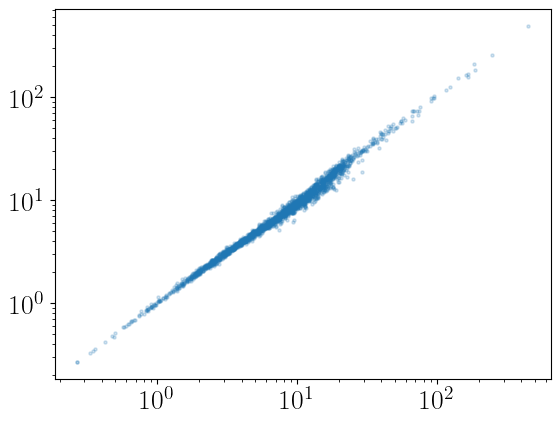

In [17]:
%matplotlib inline
plt.scatter(data["distance"], data["distance_with_feh_term"], alpha=0.2, s=5)
#plt.scatter(data["distance"], data["geometric_distance"], alpha=0.2, s=5)
plt.xscale("log")
plt.yscale("log")

### Recalculate Galactic coordinates with Cepheid distances

In [18]:
data["X"], data["Y"], data["Z"], data["R"], data["Phi"] = cepheid_utils.calc_galcen_coords(data["l"], data["b"], data["distance"])
# Also recalculate the [Fe/H] proxy
data["Fe_H_proxy"] = np.round(0.57 - 0.06 * data["R"], 2)

Text(0, 0.5, '1 / distance$_{\\rm Ripepi+2022}$   [mas]')

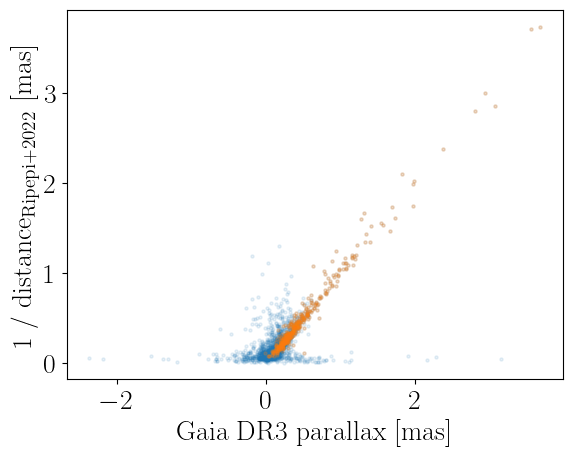

In [19]:
plt.scatter(data["parallax"], 1. / data["distance"], alpha=0.1, s=5)
plt.scatter(data["parallax"][data["__Fe_H_"].mask==False],
            1. / data["distance"][data["__Fe_H_"].mask==False], alpha=0.2, s=5)
plt.xlabel("Gaia DR3 parallax [mas]")
plt.ylabel(r"1 / distance$_{\rm Ripepi+2022}$   [mas]")


## Ages

Ages are computed using the recipe described in Dekany+2019:

```
We used the theoretical period-age relations derived by Anderson et al. (2016) to compute individual age estimates for each star. In addition to the pulsation period and metallicity, a Cepheid’s age estimate also depends on which instability strip crossing it is going through, as well as its rotational history. Although in an ideal case, these could be constrained by measurements of the period change rate, effective temperature and surface CNO abundances, in the present case these quantities remain unknown, therefore we relied on period-age relations averaged over the full range of possible stellar rotation and instability strip crossings, derived for metallicities Z = {0.002, 0.006, 0.014} (Table 4 of Anderson et al. 2016).
In the absence of individual metallicities, we estimated [Fe/H] values from the radial metallicity gradient found by Genovali et al. (2014) and Luck (2018) using Cepheids at the near side of the Galactic disk. These were converted into estimates of absolute heavy element content by log Z = [Fe/H] − 1.77, assuming a helium content of Y = 0.245, no α-element enhancement, and the Solar heavy element mixture measured by Grevesse & Sauval (1998), and we considered only objects with [Fe/H] > −0.4. Age estimates were obtained by quadratically interpolating between the relations for the 3 tabulated Z values.
```

The only work that directly reports ages in their catalogue is Skowron+2019. Their ages were computed in a very similar manner (supplemental material of their Science article):

```
We used the Period-Age relations (Anderson+2016) to derive ages of Galactic Cepheids from our sample. Because the progenitors of classical Cepheids – B/A-type main sequence stars – are typically fast rotators (Huang+2010, Zorec & Royer 2012) we assumed the Period-Age relations for ω = 0.5 (where ω is the ratio of the initial angular velocity of the star to the critical one). [FA: This is exactly Table 4 of Anderson+2016!]
[...]
We first extrapolated the relations from ref. (Anderson+2016) to metallicity of 0.030 to cover the full range of Galactic Cepheid metallicities. Over the whole range of Cepheid periods the more metal-rich Cepheids are younger than the less metal-rich ones at the same pulsation period.
There is a radial metallicity gradient in the Galaxy (Genovali+2014). For each Cepheid from our sample we estimated its typical metallicity based on the distance R from the center. Then we applied the appropriate (for fundamental-mode or first-overtone pulsations and ω = 0.5) Period-Age relation (24) to derive its age.
```

In [20]:
import importlib
importlib.reload(cepheid_utils)

<module 'cepheid_utils' from '/home/friedel/Desktop/cepheids_age_distribution/cepheid_utils.py'>

In [21]:
# For unknown [Fe/H], we use the [Fe/H] proxy from Galactocentric distance
data["logt"] = cepheid_utils.get_cepheidages(data["Period"], data["Fe_H_proxy"], usefeh=True, 
                                             mode="fundamental")
# For known [Fe/H], we use the [Fe/H] proxy from Galactocentric distance
data["logt"][feh_mask] = cepheid_utils.get_cepheidages(data["Period"][feh_mask], 
                                                       data["Fe_H_proxy"][feh_mask], usefeh=True, 
                                                       mode="fundamental")
# Get rid of values outside the clibration range
data["logt"][(data["logt"] < 7)] = np.nan
data["ageMyr"]=10.**(data["logt"] - 6)
data["logt_no_feh_dep"] = cepheid_utils.get_cepheidages(data["Period"], data["Fe_H_proxy"], usefeh=False, 
                                             mode="fundamental")
data["ageMyr_no_feh_dep"]=10.**(data["logt_no_feh_dep"] - 6)

In [22]:
data

Source,Name,Mode(s),Period,source_id,l,b,parallax,parallax_error,ruwe,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,__Fe_H_,e__Fe_H_,r__Fe_H_,geometric_distance,Fe_H_proxy,distance,distance_with_feh_term,X,Y,Z,R,Phi,logt,ageMyr,logt_no_feh_dep,ageMyr_no_feh_dep
,,,,,deg,deg,mas,mas,,mag,mag,mag,,,,,,,,,,,,,,,,
bytes11,bytes19,bytes6,float64,int64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
GCVS,AW____Per,F,6.4634539,174489098011145216,166.61765513134935,-5.385878519793774,1.0566163862524083,0.028701555,1.1555363,7.085648,7.769703,6.2850394,0.01,0.12,G18,0.948094809480948,0.03,0.8598572277465687,0.8462169254734297,-9.03281665061974,0.19813374312915302,-0.08070872562594476,9.034989409173626,358.74342549409494,7.94750069570933,88.61366431871755,7.996204923891309,99.12995839203855
Gaia-DR3,175811260743708672,F,2.1137996,175811260743708672,165.0321922651587,-11.100403665899368,0.11141440167138295,0.022758543,1.3216156,13.649755,14.139874,12.99287,--,--,--,8.79087908790879,-0.58,11.35263019933404,9.91070971222857,-18.962261269295944,2.87725914809733,-2.185709177574625,19.179311057760934,351.3719781561007,8.453654917739463,284.2201849632466,8.283562223661752,192.11541959320445
ATLAS,J076.9816+33.0565,F,1.6681269,181620805307496192,172.07327810286375,-4.4068989939190875,0.08547562695793764,0.024270382,1.1406713,14.620964,15.3244,13.801907,--,--,--,10.81908190819082,-0.57,10.933545599382299,9.167826577886425,-18.99706225043174,1.503349075776596,-0.8401236161634915,19.056453830406564,355.47527817281343,8.525631426331852,335.4528039242541,8.344440381209846,221.02448189484429
Gaia-DR3,183814674602852480,F,4.2480223,183814674602852480,171.56671954219576,-1.2596768770420557,0.1647697958715106,0.026044171,0.96799594,14.398995,15.705554,13.277649,--,--,--,6.108610861086108,-0.42,8.28560537812944,7.436825043129032,-16.394034978534407,1.2148535502516749,-0.18214857694473102,16.438985735925705,355.7619347523779,8.204198476267559,160.0289207286687,8.10411342155788,127.09059752188875
ASASSN-V,J050149.92+371627.8,F,2.4154235,186678245267045376,167.95093180960666,-2.852933003399855,-0.02803331130382197,0.038544443,1.8460361,14.514585,15.302934,13.586365,--,--,--,17.968796879687968,-0.59,11.216900444021022,8.092923737140895,-19.156186841086637,2.338618008398891,-0.5582931891680274,19.298409998749335,353.03968166261075,8.41376205782836,259.27584469713554,8.249267973919574,177.52845517215962
GCVS,IN____Aur,F,4.9107481,187324728037490048,169.48940673290434,-0.6219147154007384,0.09064551667155007,0.018349553,1.3618727,13.117223,14.096365,12.1314335,-0.31,0.12,G18,10.603060306030603,-0.37,7.57645975822379,6.210364699458911,-15.64889700444722,1.3819960203879498,-0.08223676035450499,15.709802368462986,354.95314937703915,8.152591806023942,142.09925664114942,8.06684058688633,116.63814038821675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCVS,AG____Cru,F,3.837276,6059635702888301952,301.6721267885628,3.0530901286981154,0.7421630410367415,0.019866327,1.016112,8.119241,8.58566,7.4686728,0.05,0.12,G18,1.3501350135013501,0.12,1.3532098075561083,1.3966246730746128,-7.490495282693725,-1.1500370545118281,0.07207366118036758,7.578265290078409,8.728625245807734,8.015598558135697,103.65698153336963,8.13025836186131,134.9765619590954


Let's check if the ages are consistent between the 2 methods:

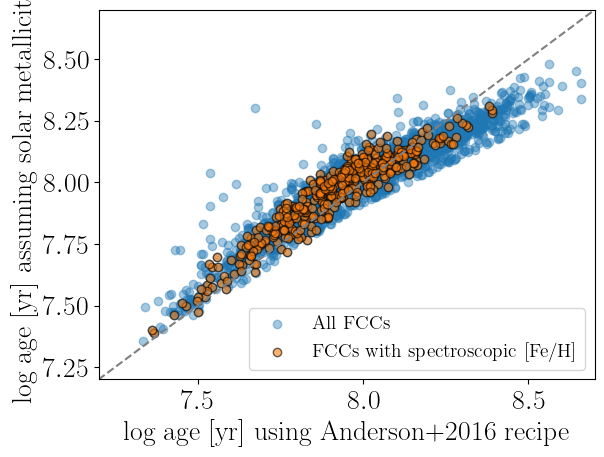

In [23]:
plt.scatter(data["logt"], data["logt_no_feh_dep"], alpha=0.4, label="All FCCs")
plt.scatter(data["logt"][feh_mask], data["logt_no_feh_dep"][feh_mask], alpha=0.6, 
            edgecolor="k", label="FCCs with spectroscopic [Fe/H]")
plt.plot([7.2,8.7],[7.2,8.7], c="grey", ls="dashed")
plt.axis([7.2,8.7,7.2,8.7])
plt.xlabel("log age [yr] using Anderson+2016 recipe")
plt.ylabel("log age [yr] assuming solar metallicity")
plt.legend(loc="lower right", fontsize=14)

In [24]:
data.write("./data/FCC_sample_April2024.fits", overwrite=True)

## Mapping Cepheids in the XY plane

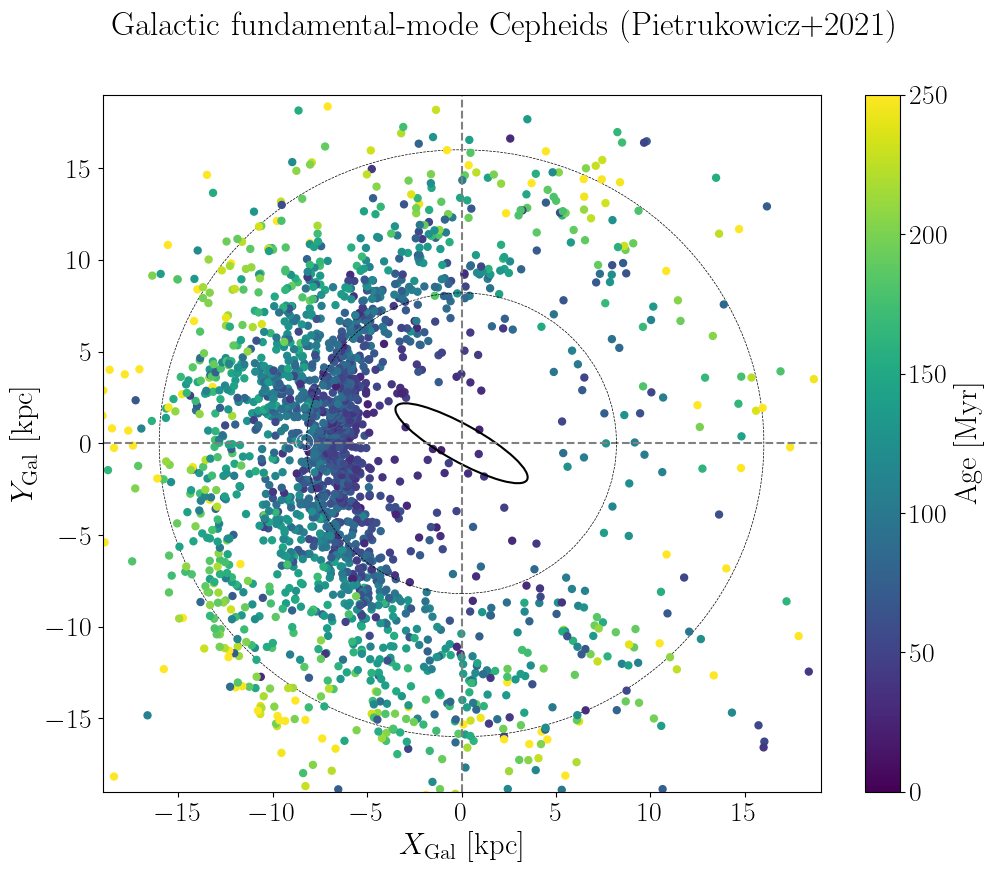

In [25]:
fig = plt.figure(figsize=(10.5, 9.))
ax  = plt.subplot(111)

scale = 19

xrange=(-scale, scale)
yrange=(-scale, scale)

vmin = 0
vmax = 250
cmap = "viridis"
ec   = None

# PLOT  

sc = plt.scatter(data["X"], data["Y"], s=25, c=data["ageMyr"], marker="o",
                edgecolor=ec, cmap=cmap, vmin=vmin, vmax=vmax)

# Beautify  the plot
plt.axis([xrange[0], xrange[1], yrange[0], yrange[1]])

ax.set_xlabel(r"$X_{\rm Gal}$  [kpc]", fontsize=22)
ax.set_ylabel(r"$Y_{\rm Gal}$    [kpc]", fontsize=22)
#ax.legend(loc="upper left", fontsize=15)
e1 = patches.Ellipse((0, 0.), 8., 2.,
                     angle=-30., linewidth=1.5, fill=False, zorder=1)
ax.add_patch(e1)
e2 = patches.Ellipse((0, 0.), 16.4, 16.4, ls="dashed",
                     angle=0., linewidth=0.5, fill=False, zorder=5)
ax.add_patch(e2)
e3 = patches.Ellipse((0, 0.), 32., 32., ls="dashed",
                     angle=0., linewidth=0.5, fill=False, zorder=0)
ax.add_patch(e3)

plt.axvline(0, ls="dashed", c="grey")
plt.axhline(0, ls="dashed", c="grey")

plt.text(-8.8, -.29, r"$\odot$", color="white", zorder=6)

cb = fig.colorbar(sc, ax=ax)
cb.set_label('Age [Myr]', fontsize=22)
plt.suptitle("Galactic fundamental-mode Cepheids (Pietrukowicz+2021)", fontsize=24)
plt.tight_layout()
plt.savefig("./im/XYmap_cepheids_18kpc_ages.png", dpi=200)
plt.show()

/tmp/ipykernel_43594/3868600567.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


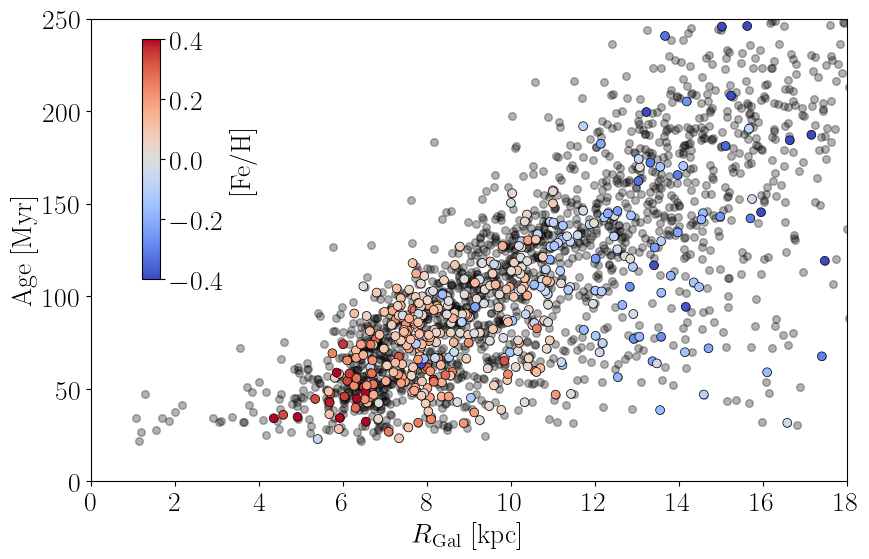

In [32]:
fig = plt.figure(figsize=(9, 6))
ax  = plt.subplot(111)
plt.scatter(data["R"], data["ageMyr"],
            s=30, c="k", marker="o", alpha=0.3)

# Overplot Cepheids with known metallicities in colour
spec = np.isfinite(data["__Fe_H_"])
plt.scatter(data["R"][spec], 
            data["ageMyr"][spec],
            s=40, c=data["__Fe_H_"][spec], marker="o", edgecolor="k",
            lw=.5, vmin=-.4, vmax=0.4, cmap="coolwarm")

plt.axis([0, 18, 0, 250])
ax.set_xlabel(r"$R_{\rm Gal}$    [kpc]", fontsize=20)
ax.set_ylabel(r"Age [Myr]", fontsize=20)

cax = fig.add_axes([0.18, 0.5, 0.02, 0.4])
norm = matplotlib.colors.Normalize(vmin=-0.4, vmax=0.4)
cb = matplotlib.colorbar.ColorbarBase(cax, norm=norm, cmap="coolwarm") #, cmap="inferno", norm=norm, spacing='proportional'
cb.set_label('[Fe/H]')
plt.tight_layout()
plt.savefig("./im/R_age_pietru.png")
plt.show()

## Period distribution instead of age

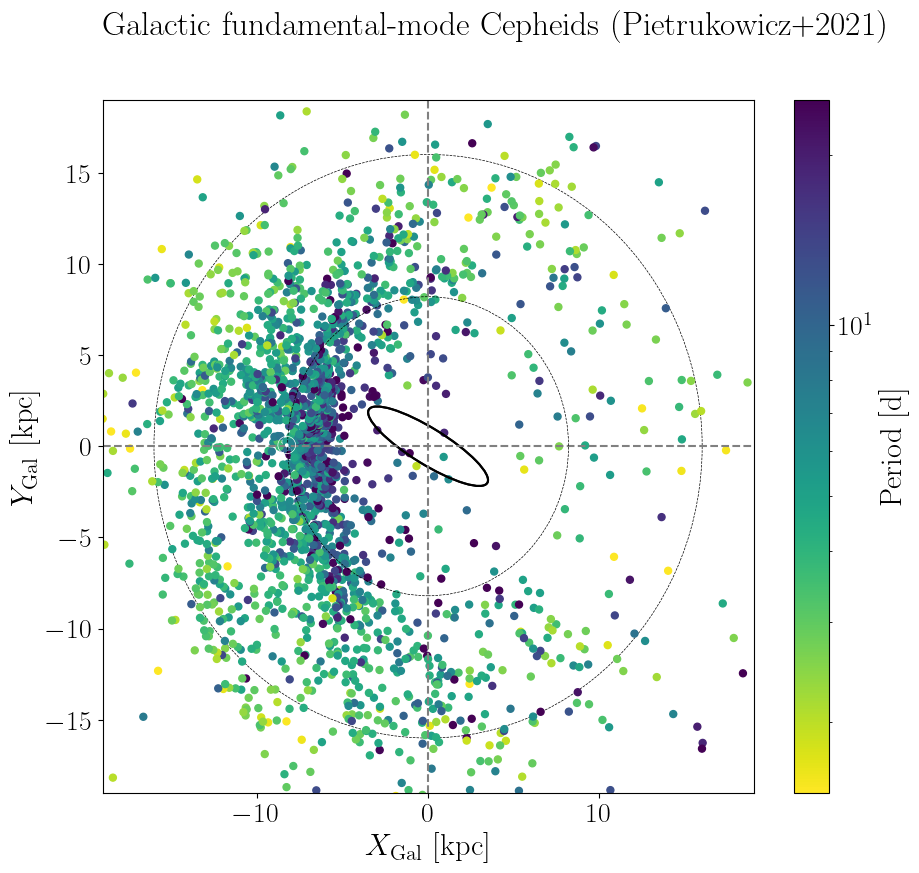

In [26]:
fig = plt.figure(figsize=(10.5, 9.))
ax  = plt.subplot(111)

scale = 19

xrange=(-scale, scale)
yrange=(-scale, scale)

vmin = 1.5
vmax = 25
cmap = "viridis_r"
ec   = None

# PLOT  
sc = plt.scatter(data["X"], data["Y"], s=25, c=data["Period"], marker="o",
            edgecolor=ec, cmap=cmap, norm=colors.LogNorm(vmin=vmin, vmax=vmax)) 

# Beautify  the plot
plt.axis([xrange[0], xrange[1], yrange[0], yrange[1]])

ax.set_xlabel(r"$X_{\rm Gal}$  [kpc]", fontsize=22)
ax.set_ylabel(r"$Y_{\rm Gal}$    [kpc]", fontsize=22)
#ax.legend(loc="upper left", fontsize=15)
e1 = patches.Ellipse((0, 0.), 8., 2.,
                     angle=-30., linewidth=1.5, fill=False, zorder=1)
ax.add_patch(e1)
e2 = patches.Ellipse((0, 0.), 16.4, 16.4, ls="dashed",
                     angle=0., linewidth=0.5, fill=False, zorder=5)
ax.add_patch(e2)
e3 = patches.Ellipse((0, 0.), 32., 32., ls="dashed",
                     angle=0., linewidth=0.5, fill=False, zorder=0)
ax.add_patch(e3)

plt.axvline(0, ls="dashed", c="grey")
plt.axhline(0, ls="dashed", c="grey")

plt.text(-8.8, -.29, r"$\odot$", color="white", zorder=6)
ax.add_patch(e1)
cb = fig.colorbar(sc, ax=ax)
cb.set_label('Period [d]', fontsize=22)

plt.suptitle("Galactic fundamental-mode Cepheids (Pietrukowicz+2021)", fontsize=24)
plt.savefig("./im/XYmap_cepheids_18kpc_periods.png", dpi=200)

## Looking at the radial metallicity profile colour-coded by age

In [27]:
from scipy.interpolate import make_interp_spline
def running_median(X, Y, nbins=10):
    bins = np.linspace(np.nanquantile(X, 0.005),np.nanquantile(X, 0.995), nbins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(X, bins, right=False)
    med = [np.nanquantile(Y[idx==k], 0.5) for k in range(1, nbins)]
    q16 = [np.nanquantile(Y[idx==k], 0.16) for k in range(1, nbins)]
    q84 = [np.nanquantile(Y[idx==k], 0.84) for k in range(1, nbins)]
    N   = np.array([len(Y[idx==k]) for k in range(1, nbins)])
    return bins[1:] - delta/2, med, q16, q84, N

# Overplot running median
def overplot_trend(X, Y, alpha=0.2, color="k", bins=10, label="", lw=3):
    #lines = mdline(X, Y, bins=bins)
    lines = running_median(X, Y, nbins=bins)
    xnew  = np.linspace(lines[0].min(), lines[0].max(), bins)
    spl   = make_interp_spline(lines[0], lines[1], k=2)
    power_smooth = spl(xnew)
    plt.plot(lines[0], lines[1], ms=50, color=color, lw=lw, label=label)
    plt.fill_between(lines[0], lines[2], lines[3], alpha=alpha, color=color)


### Ripepi sample

In [28]:
### Computing the migration scale with the simple diffusion model of Frankel+2018
def sigma_R(age_Myr):
    return 3.6 *np.sqrt(age_Myr / 8000.) # in kpc

/home/friedel/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


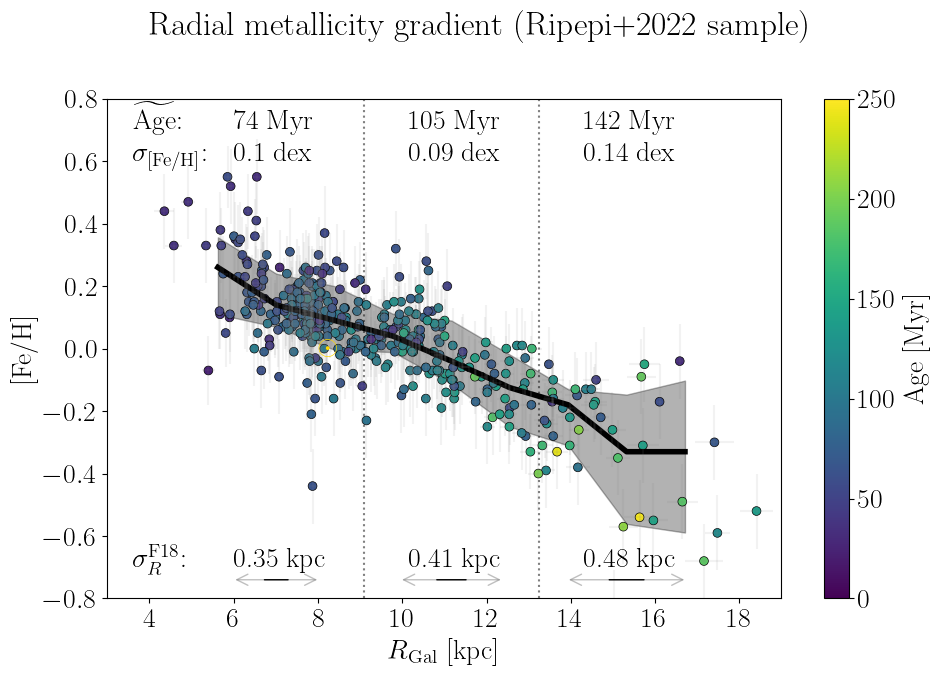

In [29]:
fig = plt.figure(figsize=(10, 7))
ax  = plt.subplot(111)

vmin = 0
vmax = 250
cmap = "viridis"

# Overplot Cepheids with known metallicities in colour
spec = np.isfinite(data["__Fe_H_"])
overplot_trend(data["R"][spec], data["__Fe_H_"][spec], 
                           alpha=0.3, bins=10, lw=4)
sc = plt.errorbar(data["R"][spec], data["__Fe_H_"][spec],
                  xerr=0.05*data["distance"][spec]*np.abs(np.cos(np.deg2rad(data["l"][spec]))), 
                  yerr=data["e__Fe_H_"][spec], 
                  ls="None", alpha=0.1, c="grey")
sc = plt.scatter(data["R"][spec], 
            data["__Fe_H_"][spec],
            s=40, c=data["ageMyr"][spec], marker="o", edgecolor="k",
            lw=.5, cmap=cmap, vmin=vmin, vmax=vmax)
plt.axis([3, 19, -0.8, 0.8])
ax.set_xlabel(r"$R_{\rm Gal}$    [kpc]", fontsize=20)
ax.set_ylabel(r"[Fe/H]", fontsize=20)

# median ages as a function of R
Rbin, med_age, q16_age, q84_age, N_Rbin = running_median(data["R"][spec], data["ageMyr"][spec], nbins=4)
# compute [Fe/H] dispersions as a function of R
# first take the median trend as in the plot (10 R bins)
Rbin10, med_feh, q16_feh, q84_feh, N_Rbin10 = running_median(data["R"][spec], data["__Fe_H_"][spec], 
                                                             nbins=10)

# then compute the dispersion in the wider bins
binedges = 0.5*(Rbin[1:] + Rbin[:-1])

plt.text(3.6, 0.7, r"$\widetilde{\rm Age}$: ")
plt.text(3.6, -0.7, r"$\sigma_{R}^{\rm F18}$: ")
plt.text(3.6, 0.6, r"$\sigma_{\rm [Fe/H]}$: ")
plt.text(8., -.02, r"\textbf{$\odot$}", color="gold", zorder=9)

for ii in range(3):
    if ii < 2:
        plt.axvline(binedges[ii], ls="dotted", c="grey", zorder=0)
    plt.text(Rbin[ii]-1, 0.7, str(np.round(med_age[ii]))[:-2]+" Myr")
    sel = list(np.array([0,1,2]) + ii*3)
    feh_disp = np.average(0.5*(np.array(q84_feh)[sel]-np.array(q16_feh)[sel]), 
                          weights=np.array(N_Rbin10)[sel])
    plt.text(Rbin[ii]-1, 0.6, str(np.round(feh_disp,2))+" dex")
    plt.text(Rbin[ii]-1, -0.7, str(np.round(sigma_R(med_age[ii]),2))+" kpc")
    plt.annotate('', xy=(Rbin[ii]-3*sigma_R(med_age[ii]),-.74), 
                 xytext=(Rbin[ii]+3*sigma_R(med_age[ii]),-.74), 
                 arrowprops=dict(arrowstyle='<->', color="grey", alpha=.5))
    plt.annotate('', xy=(Rbin[ii]-1*sigma_R(med_age[ii]),-.74), 
                 xytext=(Rbin[ii]+1*sigma_R(med_age[ii]),-.74), 
                 arrowprops=dict(arrowstyle='-', color="black"))
cb = fig.colorbar(sc, ax=ax)
cb.set_label('Age [Myr]')
plt.suptitle("Radial metallicity gradient (Ripepi+2022 sample)", fontsize=24)
plt.tight_layout()
plt.savefig("./im/R_feh_age_ripepi.png")
plt.show()

### Luck+2018 sample

In [30]:
luck1 = Table.read("./data/luck2018_tab1.fit")
luck7 = Table.read("./data/luck2018_tab7.fit")
luck  = astropy.table.join(luck1, luck7, keys=["Name"], join_type='inner')
# Only use fundamental-mode Cepheids
luck = luck[ luck["Mode"] == "F" ]
# Calculate [Fe/H] from A(Fe)
luck["Fe_H"] = luck["Feavg"] - 7.47
# Calculate ages
luck["logt"] = cepheid_utils.get_cepheidages(luck["Per"], luck["Fe_H"], usefeh=True, 
                                             mode="fundamental")
# Get rid of values outside the calibration range
luck["logt"][(luck["logt"] < 7)] = np.nan
luck["ageMyr"]=10.**(luck["logt"] - 6)
# Correct for R0 difference (Luck 2018 used R0 = 7.9 kpc)
luck["RGal"] = luck["RG-PL"] + 0.3
luck

/home/friedel/Desktop/cepheids_age_distribution/cepheid_utils.py:137: RuntimeWarning: divide by zero encountered in log10
  logt  = alphaZ(np.array(np.maximum(-0.4, Z_proxy))) * np.log10(period) + \


recno_1,Name,more,GLON,GLAT,Type,r_Type,Per,r_Per,Mode,Vmagmean,E_B-V_,E_B-V_M17,E_B-V_T16,d-PL,Plx,e_Plx,Ratio,d,dmin,dmax,RG-PL,RG-Plx,RG-BJ,Simbad,_RA_icrs,_DE_icrs,recno_2,Feavg,Femed,RFeavg,o_Feavg,Li,RLi,o_Li,Cavg,__C_Fe_,R_C_Fe_,o__C_Fe_,Navg,__N_Fe_,R_N_Fe_,o__N_Fe_,Oavg,__O_Fe_,R_O_Fe_,o__O_Fe_,__Na_H_,__Na_Fe_,R_Na_Fe_,o__Na_Fe_,__Mg_H_,__Mg_Fe_,R_Mg_Fe_,o__Mg_Fe_,__Al_H_,__Al_Fe_,R_Al_Fe_,o__Al_Fe_,__Si_H_,__Si_Fe_,R_Si_Fe_,o__Si_Fe_,__S_H_,__S_Fe_,R_S_Fe_,o__S_Fe_,__Ca_H_,__Ca_Fe_,R_Ca_Fe_,o__Ca_Fe_,__Sc_H_,__Sc_Fe_,R_Sc_Fe_,o__Sc_Fe_,__Ti_H_,__Ti_Fe_,R_Ti_Fe_,o__Ti_Fe_,__V_H_,__V_Fe_,R_V_Fe_,o__V_Fe_,__Cr_H_,__Cr_Fe_,R_Cr_Fe_,o__Cr_Fe_,__Mn_H_,__Mn_Fe_,R_Mn_Fe_,o__Mn_Fe_,__Fe_H_,R_Fe_H_,o__Fe_H_,__Co_H_,__Co_Fe_,R_Co_Fe_,o__Co_Fe_,__Ni_H_,__Ni_Fe_,R_Ni_Fe_,o__Ni_Fe_,__Cu_H_,__Cu_Fe_,R_Cu_Fe_,o__Cu_Fe_,__Zn_H_,__Zn_Fe_,R_Zn_Fe_,o__Zn_Fe_,__Rb_H_,__Rb_Fe_,R_Rb_Fe_,o__Rb_Fe_,__Sr_H_,__Sr_Fe_,R_Sr_Fe_,o__Sr_Fe_,__Y_H_,__Y_Fe_,R_Y_Fe_,o__Y_Fe_,__Zr_H_,__Zr_Fe_,R_Zr_Fe_,o__Zr_Fe_,__Ba_H_,__Ba_Fe_,R_Ba_Fe_,o__Ba_Fe_,__La_H_,__La_Fe_,R_La_Fe_,o__La_Fe_,__Ce_H_,__Ce_Fe_,R_Ce_Fe_,o__Ce_Fe_,__Nd_H_,__Nd_Fe_,R_Nd_Fe_,o__Nd_Fe_,__Sm_H_,__Sm_Fe_,R_Sm_Fe_,o__Sm_Fe_,__Eu_H_,__Eu_Fe_,R_Eu_Fe_,o__Eu_Fe_,Fe_H,logt,ageMyr,RGal
,,,deg,deg,,,d,,,mag,mag,mag,mag,pc,mas,mas,,pc,pc,pc,kpc,kpc,kpc,,deg,deg,,,,,,,,,,log(Sun),,,,log(Sun),,,,log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,log(Sun),log(Sun),,,,d,d,kpc
int32,bytes13,bytes1,float64,float64,bytes8,bytes1,float64,bytes1,bytes1,float64,float64,float64,float64,int32,float64,float64,float64,int32,int32,int32,float64,float64,float64,bytes6,float64,float64,int32,float64,float64,float64,int16,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,float64
248,AA Gem,*,184.5896,2.7007,DCEP,,11.3028,,F,9.72,0.309,0.0,0.0,3646,0.1878,0.053,3.5419,4230,3460,5353,11.534,13.208,12.117,Simbad,91.6456,26.3292,1,7.283,7.283,0.046,2,0.737,0.073,2,7.977,-0.261,0.212,2,0.0,0.0,0.0,0,8.521,0.024,0.003,2,0.206,0.398,0.127,2,-0.035,0.157,0.01,2,0.091,0.283,0.144,2,0.005,0.197,0.014,2,0.001,0.193,0.204,2,-0.177,0.015,0.164,2,0.026,0.218,0.055,2,-0.093,0.1,0.049,2,-0.246,-0.054,0.012,2,0.016,0.208,0.021,2,-0.249,-0.057,0.001,2,-0.192,0.046,2,-0.174,0.018,0.046,2,-0.226,-0.034,0.082,2,-0.487,-0.295,0.1,2,-0.116,0.076,0.16,2,0.0,0.0,0.0,0,0.232,0.424,0.0,1,-0.139,0.053,0.104,2,-0.087,0.105,0.191,2,0.0,0.0,0.0,0,0.11,0.302,0.09,2,0.039,0.231,0.258,2,-0.04,0.153,0.001,2,-0.146,0.046,0.154,2,-0.422,-0.23,0.08,2,-0.1869999999999994,7.880299925401447,75.91016324907211,11.834000000000001
289,AA Mon,*,217.0311,-0.4286,DCEP,,3.9382,,F,12.71,0.792,0.0,0.742,4313,0.2123,0.0405,5.2415,4014,3439,4795,11.636,11.999,11.364,Simbad,104.3491

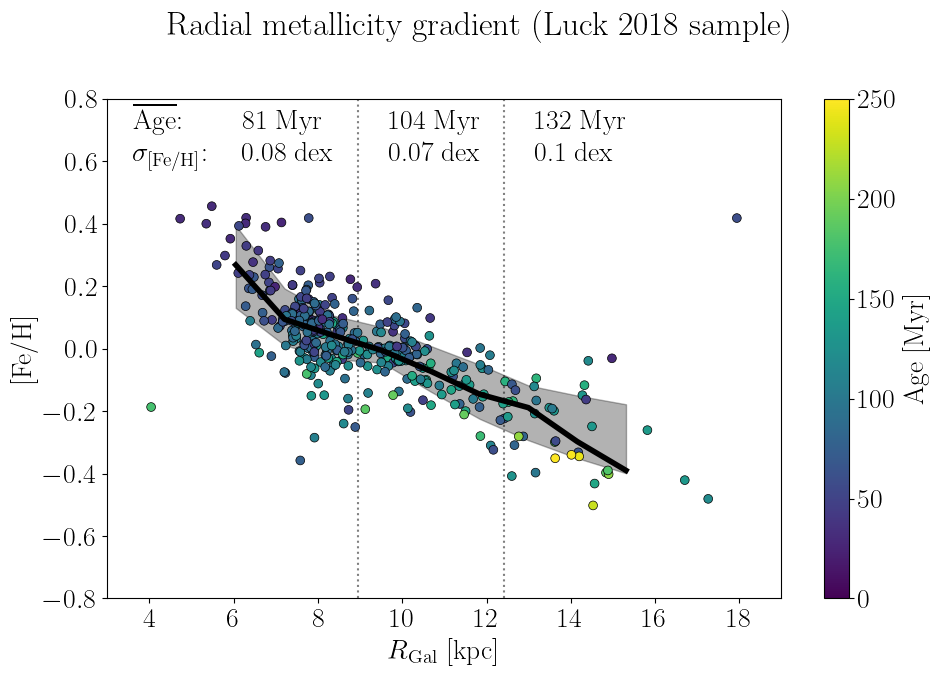

In [31]:
fig = plt.figure(figsize=(10, 7))
ax  = plt.subplot(111)

ok = (luck["RGal"] > 4.5) & (luck["RGal"] < 17.5)
vmin = 0
vmax = 250
cmap = "viridis"

# Overplot Cepheids with known metallicities in colour
overplot_trend(luck["RGal"][ok], luck["Fe_H"][ok], alpha=0.3, bins=10, lw=4)
sc = plt.scatter(luck["RGal"], luck["Fe_H"],
            s=40, c=luck["ageMyr"], marker="o", edgecolor="k",
            lw=.5, cmap=cmap, vmin=vmin, vmax=vmax)
plt.axis([3, 19, -0.8, 0.8])
ax.set_xlabel(r"$R_{\rm Gal}$    [kpc]", fontsize=20)
ax.set_ylabel(r"[Fe/H]", fontsize=20)

# median ages as a function of R
Rbin, med_age, q16_age, q84_age, N_Rbin = running_median(luck["RGal"][ok], luck["ageMyr"][ok], nbins=4)
# compute [Fe/H] dispersions as a function of R
# first take the median trend as in the plot (10 R bins)
Rbin10, med_feh, q16_feh, q84_feh, N_Rbin10 = running_median(luck["RGal"][ok], luck["Fe_H"][ok], 
                                                             nbins=10)

# then compute the dispersion in the wider bins
binedges = 0.5*(Rbin[1:] + Rbin[:-1])

plt.text(3.6, 0.7, r"$\overline{\rm Age}$: ")
plt.text(3.6, 0.6, r"$\sigma_{\rm [Fe/H]}$: ")

for ii in range(3):
    if ii < 2:
        plt.axvline(binedges[ii], ls="dotted", c="grey", zorder=0)
    plt.text(Rbin[ii]-1, 0.7, str(np.round(med_age[ii]))[:-2]+" Myr")
    sel = list(np.array([0,1,2]) + ii*3)
    feh_disp = np.average(0.5*(np.array(q84_feh)[sel]-np.array(q16_feh)[sel]), 
                          weights=np.array(N_Rbin10)[sel])
    plt.text(Rbin[ii]-1, 0.6, str(np.round(feh_disp,2))+" dex")
cb = fig.colorbar(sc, ax=ax)
cb.set_label('Age [Myr]')
plt.suptitle("Radial metallicity gradient (Luck 2018 sample)", fontsize=24)
plt.tight_layout()
plt.savefig("./im/R_feh_age_luck.png")
plt.show()

### Fitting the data à la Anders+2017

First define a couple of useful fitting functions (taken from [here](https://github.com/fjaellet/xgboost_chem_ages/blob/main/py/utils.py)):

In [32]:
import emcee
import corner
import scipy.optimize as op

# Define the probability function as likelihood * prior.
def lnprior(theta, Nfit=3):
    if Nfit == 3:
        m, b, f = theta
        if -0.2 < m < 0.2 and -0.5 < b < 1.0 and 0 < f < 1.0:
            return 0.0
    if Nfit == 4:
        m, b, ms, bs = theta
        if -0.2 < m < 0.2 and -0.5 < b < 1.0 and \
           -0.9 < ms < 0.9 and -.9< bs <.9:
            return 0.0
    return -np.inf

def lnlike(theta, x, y, yerr, w, Nfit=3):
    if Nfit == 3:
        # linear slope + constant scatter
        m, b, f = theta
        model   = m * x + b
        sigma2  = ( yerr**2. + f**2. )
    elif Nfit == 4:
        # linear slope + scatter \propto R
        m, b, ms, bs = theta
        model   = m * x + b
        sigma2  = ( yerr**2. + (ms*x + bs)**2. )
    return -0.5*( np.sum((y-model)**2./sigma2 + np.log(sigma2) - 2.*np.log(w) ) )

def lnprob(theta, x, y, yerr, w, Nfit=4):
    lp = lnprior(theta, Nfit=Nfit)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr, w, Nfit=Nfit)

def fit_gradient_with_dispersion(x, y, yerr, w, Nfit=3, agebounds=[0,.3], guide=False):
    
    savetext=str(agebounds[0])+"_"+str(agebounds[1])
    # Do the least-squares fit and compute the uncertainties.
    A = np.vstack((np.ones_like(x), x)).T
    C = np.diag(yerr * yerr)
    cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
    b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
    print("""Least-squares results:
        m = {0} ± {1} 
        b = {2} ± {3} 
    """.format(m_ls, np.sqrt(cov[1, 1]), b_ls, np.sqrt(cov[0, 0])))

    # Find the maximum likelihood value.
    
    if Nfit == 3:
        chi2 = lambda *args: -2 * lnlike(*args)
        result = op.minimize(chi2, [-0.06, 0.5, 0.2], args=(x, y, yerr, w))
        m_ml, b_ml, f_ml = result["x"]
        print("""Maximum likelihood result:
            m = {0} 
            b = {1} 
            f = {2} 
        """.format(m_ml, b_ml, f_ml))
    elif Nfit == 4:
        chi2 = lambda *args: -2 * lnlike(*args, Nfit=4)
        result = op.minimize(chi2, [-0.06, 0.5, 0.01, 0.2],
                             args=(x, y, yerr, w))
        m_ml, b_ml, ms_ml, bs_ml = result["x"]
        print("""Maximum likelihood result:
            m  = {0} 
            b  = {1} 
            ms = {2} 
            bs = {3} 
        """.format(m_ml, b_ml, ms_ml, bs_ml))

    # Set up the sampler.
    ndim, nwalkers = Nfit, 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr, w))

    # Clear and run the production chain.
    print("Running MCMC...")
    sampler.run_mcmc(pos, 750, rstate0=np.random.get_state())
    print("Done.")

    # Make a corner plot.
    burnin = 250
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    if Nfit == 3:
        fig = corner.corner(samples, labels=[r"$m\,\, $[dex/kpc]",
                                             r"$b\,$ [dex]",
                                             r"$\sigma\,$ [dex]"],
                            show_titles=True, title_kwargs={"fontsize": 14}, 
                            title_fmt=".3f")
        fig.gca().annotate("MW Cepheids, "+str(agebounds[0])+
                       r" Gyr $<\,\tau<\,$ "+str(agebounds[1])+" Gyr",
                       xy=(0.7, 0.85), xycoords="figure fraction",
                       xytext=(0, -5), textcoords="offset points",
                       ha="center", va="top", fontsize=16)
    elif Nfit == 4:
        fig = corner.corner(samples, labels=[r"$m\,\, $[dex/kpc]",
                                             r"$b\,$ [dex]",
                                             r"$m_{\sigma}\,$ [dex/kpc]",
                                             r"$b_{\sigma}\,$ [dex]"],
                            show_titles=True, title_kwargs={"fontsize": 14}, 
                            title_fmt=".3f")
        fig.gca().annotate("MW Cepheids, "+str(agebounds[0])+
                       r" Gyr $<\,\tau<\,$ "+str(agebounds[1])+" Gyr",
                       xy=(0.7, 0.85), xycoords="figure fraction",
                       xytext=(0, -5), textcoords="offset points",
                       ha="center", va="top", fontsize=16)
    if guide:
        plt.savefig("./im/feh_gradient_guide_agebin" + savetext +"_corner.png")
    else:
        plt.savefig("./im/feh_gradient_agebin" + savetext +"_corner.png")
        
    # Compute the quantiles.
    if Nfit == 3:
        m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                     zip(*np.percentile(samples, [16, 50, 84],
                                                        axis=0)))
        print("""MCMC result:
            m = {0[0]} +{0[1]} -{0[2]} 
            b = {1[0]} +{1[1]} -{1[2]} 
            f = {2[0]} +{2[1]} -{2[2]} 
        """.format(m_mcmc, b_mcmc, f_mcmc))
    elif Nfit == 4:
        m_mcmc, b_mcmc, ms_mcmc, bs_mcmc = map(lambda v: (v[1], v[2]-v[1],
                                                          v[1]-v[0]),
                                     zip(*np.percentile(samples, [16, 50, 84],
                                                        axis=0)))
        print("""MCMC result:
            m  = {0[0]} +{0[1]} -{0[2]} 
            b  = {1[0]} +{1[1]} -{1[2]} 
            ms = {2[0]} +{2[1]} -{2[2]} 
            bs = {3[0]} +{3[1]} -{3[2]} 
        """.format(m_mcmc, b_mcmc, ms_mcmc, bs_mcmc))

    # Plot the dataset.
    plt.figure()
    plt.axis([5,18,-1,.6])
    xl = np.array([5, 18])
    #color= np.zeros((4,len(w))); color[2,:]= 1.; color[3,:]= w  # Set alpha
    #for kk in np.arange(N):
    plt.errorbar(x, y, yerr=yerr, fmt=".k", c="k", alpha=0.2)
    if guide:
        plt.xlabel(r"$R_{\rm guide}$ [kpc]", fontsize=20)
    else:
        plt.xlabel(r"$R_{\rm Gal}$ [kpc]", fontsize=20)
    plt.ylabel("[Fe/H]", fontsize=20)
    plt.tight_layout()
    # Plot the best-parameter result.
    if Nfit == 3:
        plt.fill_between(xl, m_mcmc[0]*xl+b_mcmc[0]-f_mcmc[0],
                        m_mcmc[0]*xl+b_mcmc[0]+f_mcmc[0], alpha=0.2)
    elif Nfit == 4:
        plt.fill_between(xl,(m_mcmc[0]-ms_mcmc[0])*xl+(b_mcmc[0]-bs_mcmc[0]),
                        (m_mcmc[0]+ms_mcmc[0])*xl+(b_mcmc[0]+bs_mcmc[0]),
                        alpha=0.2)
    plt.plot(xl, m_mcmc[0]*xl+b_mcmc[0], "k", c='blue')
    # Plot the least-squares result.
    plt.plot(xl, m_ls*xl+b_ls, "--k")
    # Plot the maximum likelihood result.
    plt.plot(xl, m_ml*xl+b_ml, "k", lw=2)

    # Plot some samples onto the data.
    if Nfit == 3:
        for m, b, f in samples[np.random.randint(len(samples), size=100)]:
            plt.plot(xl, m*xl+b, color="k", alpha=0.1)
    elif Nfit == 4:
        for m,b,ms,bs in samples[np.random.randint(len(samples), size=100)]:
            plt.plot(xl, m*xl+b, color="k", alpha=0.1)
    plt.errorbar(x, y, yerr=yerr, fmt=".k", c="k", alpha=0.2)
    if guide:
        plt.savefig("./im/feh_gradient_guide_agebin" + savetext +"_fit.png")
    else:
        plt.savefig("./im/feh_gradient_agebin" + savetext +"_fit.png")
    
    if Nfit == 3:
        return m_mcmc, b_mcmc, f_mcmc
    elif Nfit == 4:
        return m_mcmc, b_mcmc, ms_mcmc, bs_mcmc
        

In [33]:
R_range = (data["R"] > 5) & (data["R"] < 18)

R   = np.array(data["R"][spec & R_range])
Fe  = np.array(data["__Fe_H_"][spec & R_range])
eFe = np.array(data["e__Fe_H_"][spec & R_range])
w   = 1. / eFe

Least-squares results:
        m = -0.05356378995547068 ± 0.002387137537111632 
        b = 0.541435736493167 ± 0.023322644364316823 
    
Maximum likelihood result:
            m  = -0.05193692133171097 
            b  = 0.5278805942791448 
            ms = -0.018914718095213386 
            bs = 0.17982527848136504 
        
Running MCMC...
Done.
MCMC result:
            m  = -0.05190621834145229 +0.002934722607074794 -0.0030045054391124038 
            b  = 0.5272720372003245 +0.028519594502426915 -0.028313228316451278 
            ms = -0.018673371096337044 +0.00423086464890224 -0.0036044880116804165 
            bs = 0.1766959842961945 +0.036777415399367436 -0.04465570539276381 
        


/tmp/ipykernel_138764/1015898936.py:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(x, y, yerr=yerr, fmt=".k", c="k", alpha=0.2)
/tmp/ipykernel_138764/1015898936.py:157: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(xl, m_mcmc[0]*xl+b_mcmc[0], "k", c='blue')
/tmp/ipykernel_138764/1015898936.py:170: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(x, y, yerr=yerr, fmt=".k", c="k", alpha=0.2)


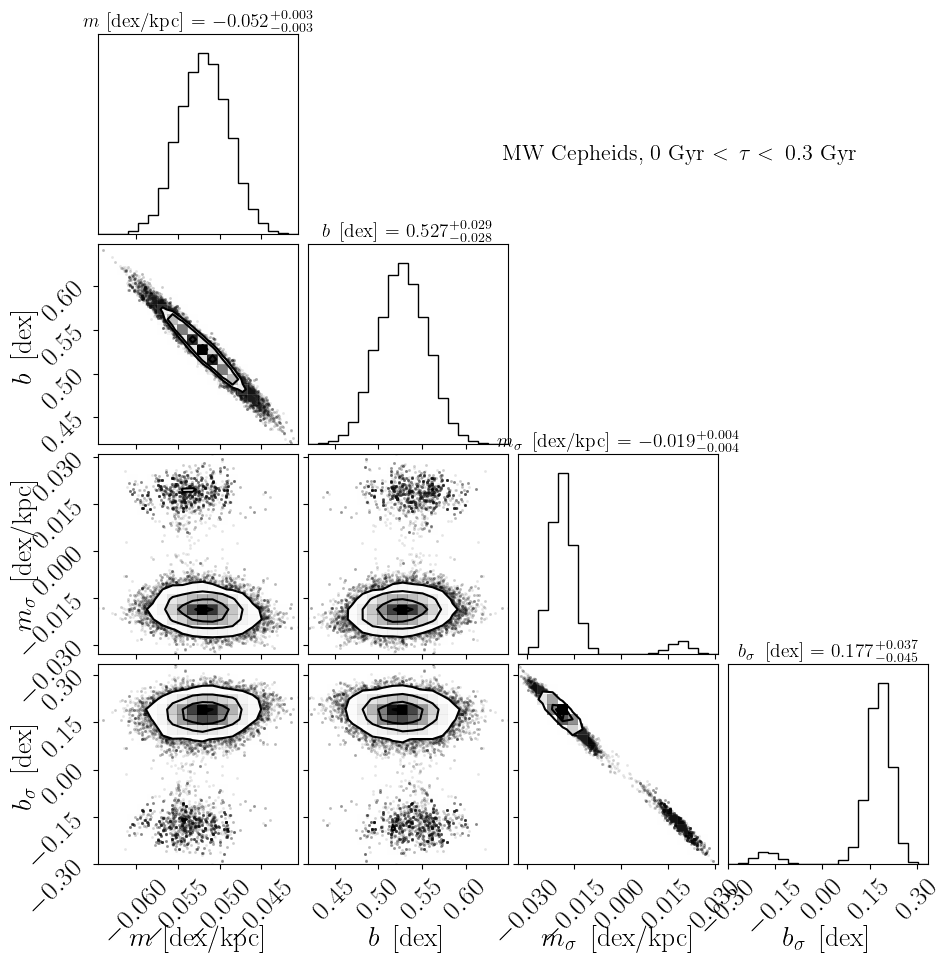

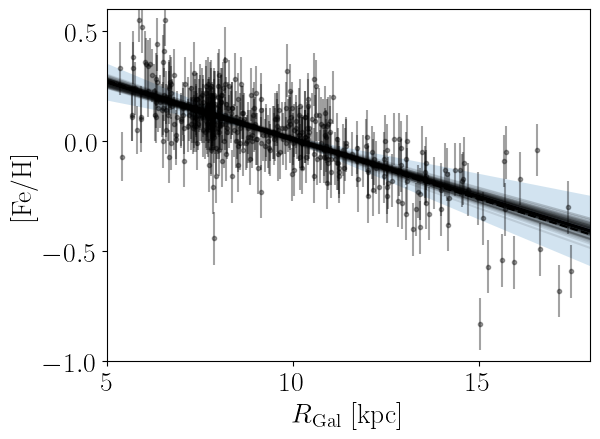

In [34]:
# Now do the fitting:
m, b, ms, bs = fit_gradient_with_dispersion(R, Fe, eFe, w, 
                                            Nfit=4, agebounds=[0, 0.3])